In [76]:
import cmdstanpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cmdstanjupyter
import arviz
plt.style.use("ggplot")

In [78]:
def sigmoid(x,a,k, x0,x1):
    y = a/(1+np.exp(-k*(x-x0))) + 1/(1+np.exp(-1*(x-x1)))*(0.1*(x-x1))
    return y

In [79]:

x=np.arange(0,100)
x0=25
x1=30

y = sigmoid(x,5,0.5,x0,x1)

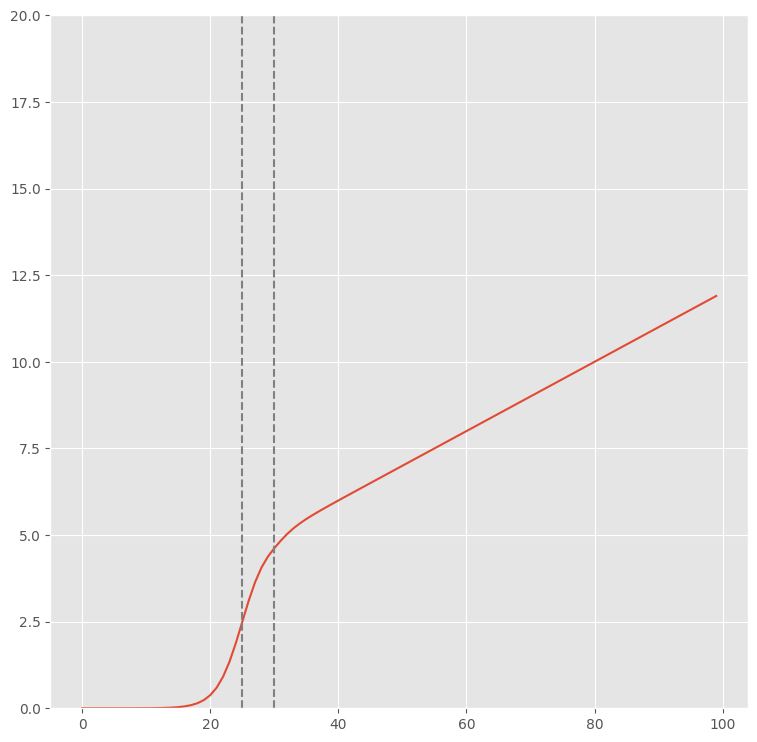

In [84]:
fig,ax= plt.subplots(figsize=(9,9))
ax.plot(x,y)
ax.set_ylim(0,20)
ax.vlines(x0,0,20, color="gray",ls="--")
ax.vlines(x1,0,20, color="gray", ls="--")

In [20]:
%load_ext cmdstanjupyter

In [3]:
df = pd.read_parquet("../../customdataset/accum_curve_dataset.parquet")

In [4]:
df["date_idx"] = df["date"].dt.dayofyear

In [5]:
%%stan model4
data {
  int N_X;
  vector[N_X] y_price;           // 0..10 を想定
}
parameters {
  real<lower=0,upper=20> a;
  real<lower=0.8,upper=1.2> x0;  // n/1000 スケールに合わせた中心
  real<lower=1e-6> sigma_y;      // ★ 0 を避ける
  real<lower=0.2> delta;         // ★ 中腹幅の下限（要調整）
}
transformed parameters {
  real k = (2.0 * log(9)) / delta;
}
model {
  // 弱情報の事前（必要に応じて調整）
  a       ~ normal(10, 5);               // 上下限が 0..10 なら a≃10 付近
  delta   ~ normal(0.8, 0.3);            // 中腹幅の事前（n/1000スケール）
  sigma_y ~ normal(0, 0.5);              // half-normal(0.5)

  for (n in 1:N_X) {
    real x = n / 1000.0;
    real mu = a / (1 + exp(-k * (x - x0)));
    y_price[n] ~ normal(mu, sigma_y);
  }
}
generated quantities {
  vector[N_X] y_new;
  for (n in 1:N_X) {
    real x = n / 1000.0;
    real mu = a / (1 + exp(-k * (x - x0)));
    y_new[n] = normal_rng(mu, sigma_y);
  }
}

INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "model4"
INFO:cmdstanjupyter:StanModel now available as variable "model4"!
 Compilation took a moment.


In [6]:
df_sel = df.query("date=='2022-01-01'").query("hour==0")

/tmp/ipykernel_1599/2291006699.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_sel = df.query("date=='2022-01-01'").query("hour==0")


In [7]:
df_sel["x_scale"] = df_sel["x"] /1000

In [8]:
df_sel = df_sel.iloc[600:].reset_index()

In [9]:
data = {
    "N_X":len(df_sel),
    "y_price":df_sel["y"].values
}

In [57]:
ds = fit.draws_xr(inc_warmup=True)

(0.0, 20.0)

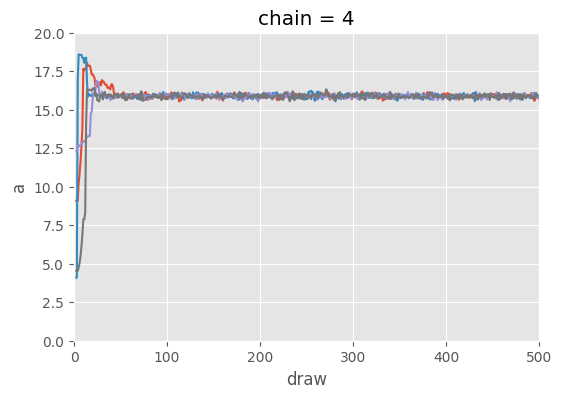

In [60]:
fig,ax = plt.subplots(figsize=(6,4))
for i in range(1,5):
    ds["a"].sel(chain=i).plot(ax=ax)
ax.set_xlim(0,500)
ax.set_ylim(0,20)

In [45]:
ds = arviz.from_cmdstanpy(fit)
ds

Inference data with groups:
	> posterior
	> sample_stats

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'x0'}>, <Axes: title={'center': 'x0'}>],
       [<Axes: title={'center': 'sigma_y'}>,
        <Axes: title={'center': 'sigma_y'}>]], dtype=object)

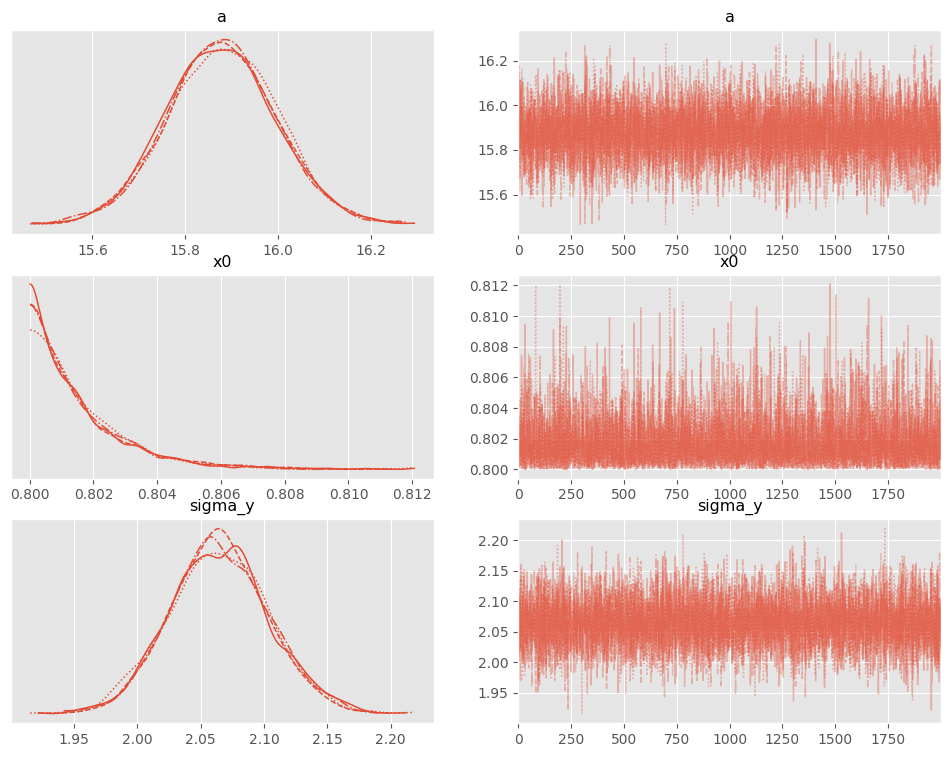

In [51]:

arviz.plot_trace(ds,var_names=["a","x0","sigma_y"],figsize=(12,9))

In [72]:
fit=model4.sample(data=data,seed=1234,iter_warmup=1000,iter_sampling=2000)

10:59:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:59:17 - cmdstanpy - INFO - CmdStan done processing.


In [11]:
fit.diagnose()

'Checking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nRank-normalized split effective sample size satisfactory for all parameters.\n\nRank-normalized split R-hat values satisfactory for all parameters.\n\nProcessing complete, no problems detected.\n'

In [108]:
fit=model2.sample(data=data,seed=1234,iter_warmup=500,iter_sampling=1000, chains=1,show_console=True)

03:07:26 - cmdstanpy - INFO - Chain [1] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 500
Chain [1] save_warmup = false (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = true (Default)
Chain [1] gamma = 0.05 (Default)
Chain [1] delta = 0.8 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] save_metric = false (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmpya571kox/2_gy08gr.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 1234
Chain [1] output
C

03:08:02 - cmdstanpy - INFO - Chain [1] done processing
03:08:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: model2_model_namespace::log_prob: k is -inf, but must be greater than or equal to 0.000000 (in 'model2.stan', line 12, column 4 to column 21)
	Exception: model2_model_namespace::log_prob: k is -inf, but must be greater than or equal to 0.000000 (in 'model2.stan', line 12, column 4 to column 21)
	Exception: model2_model_namespace::log_prob: k is -inf, but must be greater than or equal to 0.000000 (in 'model2.stan', line 12, column 4 to column 21)
	Exception: model2_model_namespace::log_prob: k is -inf, but must be greater than or equal to 0.000000 (in 'model2.stan', line 12, column 4 to column 21)
	Exception: normal_lpdf: Location parameter is nan, but must be finite! (in 'model2.stan', line 21, column 8 to column 69)
	Exception: normal_lpdf: Location parameter is nan, but must be finite! (in 'model2.stan', line 21, column 8 to column 69)
	Exception: norma

Chain [1] k=5.19177e-308x0=4.23213e+307x10=-1018.63x90=8.46426e+307
Chain [1] 
Chain [1] k=4.19764e-308x0=5.23443e+307x10=-1013.38x90=1.04689e+308
Chain [1] 
Chain [1] k=5.74804e-308x0=3.82257e+307x10=-1023.87x90=7.64513e+307
Chain [1] 
Chain [1] k=5.69818e-308x0=3.85601e+307x10=-1029.12x90=7.71202e+307
Chain [1] 
Chain [1] k=3.03694e-308x0=7.235e+307x10=-1008.13x90=1.447e+308
Chain [1] 
Chain [1] k=0x0=infx10=-1002.89x90=inf
Chain [1] 
Chain [1] Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain [1] Exception: normal_lpdf: Location parameter is nan, but must be finite! (in 'model2.stan', line 21, column 8 to column 69)
Chain [1] If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain [1] but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain [1] 
Chain [1] k=5.74804e-308x0=3.82257e

In [73]:
df = fit.summary(percentiles=[5,25,50,75,95],)

y_new_list = [f"y_new[{i}]" for i in range(1,1401+1)]
df = df.loc[y_new_list,:]

In [74]:
df = df.reset_index(drop=True)

In [75]:
df

Mean      MCSE   StdDev      MAD       5%        25%       50%  \
0      2.23226  0.023286  2.09765  2.09801 -1.25487   0.826363   2.23702   
1      2.24583  0.023096  2.07561  2.06186 -1.22927   0.837860   2.25278   
2      2.29134  0.022725  2.04605  2.04640 -1.04839   0.906602   2.29848   
3      2.23531  0.023136  2.07407  2.07143 -1.20745   0.839127   2.21710   
4      2.25813  0.023484  2.08200  2.08233 -1.12745   0.852790   2.24777   
...        ...       ...      ...      ...      ...        ...       ...   
1396  12.56490  0.023130  2.05199  2.05748  9.19989  11.161500  12.58470   
1397  12.59730  0.023395  2.07749  2.09914  9.22997  11.178800  12.55690   
1398  12.62780  0.022613  2.06370  2.04028  9.20807  11.272300  12.62150   
1399  12.59660  0.023205  2.05582  2.06689  9.26288  11.204700  12.58590   
1400  12.59250  0.023196  2.08467  2.08528  9.15133  11.184200  12.59530   

           75%       95%  ESS_bulk  ESS_tail     R_hat  
0      3.65405   5.66390   8119.74   7656.33  1.000070  
1      3.61761   5.65832   8101.17   7846.91  1.000160  
2      3.67236   5.62808   8118.86   7825.94  1.000110  
3      3.64141   5.66938   8041.95   7446.35  1.000670  
4      3.66081   5.69802   7869.81   7794.41  1.000130  
...        ...       ...       ...       ...       ...  
1396  13.92840  15.95310   7882.63   8055.27  1.000170  
1397  14.00660  16.01180   7926.22   7765.88  1.000370  
1398  14.02440  16.05720   8345.93   7656.99  0.999818  
1399  13.99180  16.00690   7870.40   7847.74  0.999915  
1400  13.99470  16.01500   8195.92   7987.53  1.000300  

[1401 rows x 12 columns]

In [76]:
df_sel

index       date     x          y  hour  date_idx  x_scale
0       600 2022-01-01   600   0.126098     0         1    0.600
1       601 2022-01-01   601   0.126098     0         1    0.601
2       602 2022-01-01   602   0.126098     0         1    0.602
3       603 2022-01-01   603   0.126098     0         1    0.603
4       604 2022-01-01   604   0.126098     0         1    0.604
...     ...        ...   ...        ...   ...       ...      ...
1396   1996 2022-01-01  1996  10.000000     0         1    1.996
1397   1997 2022-01-01  1997  10.000000     0         1    1.997
1398   1998 2022-01-01  1998  10.000000     0         1    1.998
1399   1999 2022-01-01  1999  10.000000     0         1    1.999
1400   2000 2022-01-01  2000  10.000000     0         1    2.000

[1401 rows x 7 columns]

In [77]:
df.index = df_sel.index

In [78]:
df_sel

index       date     x          y  hour  date_idx  x_scale
0       600 2022-01-01   600   0.126098     0         1    0.600
1       601 2022-01-01   601   0.126098     0         1    0.601
2       602 2022-01-01   602   0.126098     0         1    0.602
3       603 2022-01-01   603   0.126098     0         1    0.603
4       604 2022-01-01   604   0.126098     0         1    0.604
...     ...        ...   ...        ...   ...       ...      ...
1396   1996 2022-01-01  1996  10.000000     0         1    1.996
1397   1997 2022-01-01  1997  10.000000     0         1    1.997
1398   1998 2022-01-01  1998  10.000000     0         1    1.998
1399   1999 2022-01-01  1999  10.000000     0         1    1.999
1400   2000 2022-01-01  2000  10.000000     0         1    2.000

[1401 rows x 7 columns]

In [79]:
df["obs"] = df_sel["y"]

<Axes: >

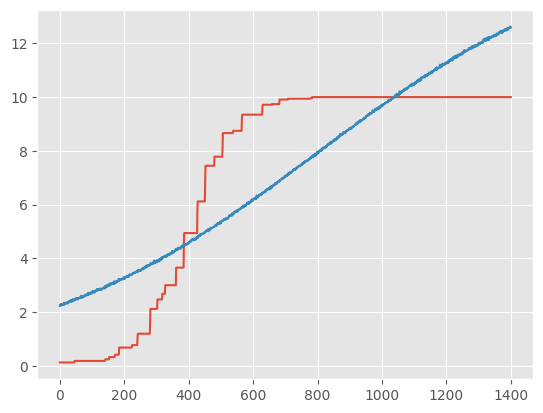

In [81]:
df["obs"].plot()
df["Mean"].plot()

In [29]:
fit=model.sample(data=data,seed=1234,iter_warmup=1000,iter_sampling=2000)

18:07:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:07:38 - cmdstanpy - INFO - CmdStan done processing.
18:07:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
	Exception: normal_lpdf: Location parameter is -nan, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
Exception: normal_lpdf: Location parameter is -nan, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
	Exception: normal_lpdf: L

18:07:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 334 divergent transitions (16.7%)
	Chain 2 had 3 iterations at max treedepth (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [30]:
fit.summary()

Mean        MCSE      StdDev       MAD          5%  \
lp__         1673.620000  237.674000  726.933000  1.356580 -923.213000   
a               9.960090    0.069888    0.225501  0.006523    9.538670   
k               0.106405    0.122903    0.413635  0.000066    0.013786   
x0            401.087000    2.861060   10.120500  0.391406  397.434000   
sigma_y         0.264571    0.135732    0.425900  0.003394    0.157087   
...                  ...         ...         ...       ...         ...   
y_new[1397]     9.962070    0.056084    0.562953  0.170818    9.672400   
y_new[1398]     9.956640    0.065622    0.552809  0.173968    9.663660   
y_new[1399]     9.967580    0.052622    0.537130  0.175985    9.657300   
y_new[1400]     9.953600    0.070701    0.550274  0.175414    9.646930   
y_new[1401]     9.960540    0.058580    0.546968  0.173813    9.661460   

                     50%         95%   ESS_bulk   ESS_tail    R_hat  
lp__         1854.570000  1855.99000    29.2939  4000.0000  1.09815  
a              10.012500    10.02250    48.0359  4000.0000  1.06990  
k               0.013886     0.13276    47.4958  4000.0000  1.07655  
x0            403.191000   403.80600    44.7122  4000.0000  1.05966  
sigma_y         0.162127     1.19281    27.4670  2396.3700  1.09669  
...                  ...         ...        ...        ...      ...  
y_new[1397]    10.008900    10.31220  5109.4100    26.8652  1.05974  
y_new[1398]    10.006900    10.30530   728.7630    22.6453  1.05875  
y_new[1399]    10.008500    10.31310  4093.3700    24.5980  1.06030  
y_new[1400]    10.004900    10.30420   862.7750    22.9329  1.05694  
y_new[1401]    10.009700    10.29970  3001.7400    24.3891  1.05519  

[1406 rows x 10 columns]

array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'x0'}>, <Axes: title={'center': 'x0'}>]],
      dtype=object)

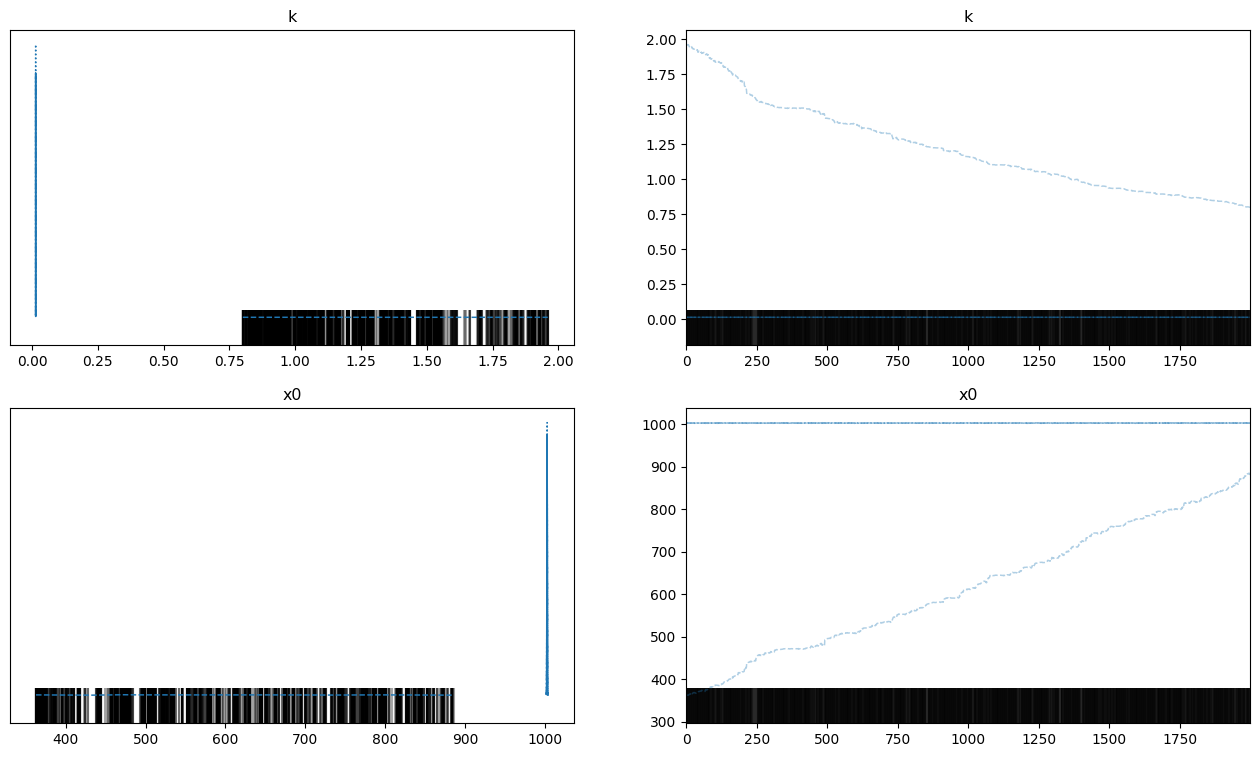

In [10]:
x=arviz.from_cmdstanpy(fit)
arviz.plot_trace(x,var_names=["k","x0"],figsize=(16,9))